*This project aims to examine the primary factors influencing the adoption of animals in a shelter environment. Through exploratory data analysis and machine learning techniques—specifically regression and classification models—it seeks to understand adoption patterns and predict the likelihood of adoption based on variables such as species, age, and adopter demographics.*

##### 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

#Load the data
df = pd.read_csv('data/pet_adoption_center.csv')

#Show first 5 rows
print(df.head())

  pet_id pet_name species              breed  age_years  gender    color  \
0  P0001   Sandra     Dog  Yorkshire Terrier          2  Female    White   
1  P0002    Brian     Cat          Tonkinese          1  Female   Golden   
2  P0003  Timothy    Bird      Amazon Parrot          4    Male  Spotted   
3  P0004     Karl     Dog    German Shepherd          1  Female    White   
4  P0005    Sarah  Rabbit              Dutch          1  Female  Spotted   

  arrival_date  adopted adoption_date adopter_id      adopter_name  \
0   2024-10-10     True    2025-03-11      A0001      Megan Rogers   
1   2023-09-09     True    2024-02-10      A0002  Jonathan Hawkins   
2   2023-10-03    False    2023-10-17        NaN               NaN   
3   2024-07-28     True    2024-08-12      A0004    Natalie Rivera   
4   2024-02-21    False    2024-02-26        NaN               NaN   

   adopter_age   adopter_city  adopter_previous_pets  
0           56      Mcgeestad                      1  
1           

##### 2. Data Cleaning and Preprocessing

In [2]:
#check for missing values
print(df.isnull().sum())

pet_id                    0
pet_name                  0
species                   0
breed                     0
age_years                 0
gender                    0
color                     0
arrival_date              0
adopted                   0
adoption_date             0
adopter_id               82
adopter_name             82
adopter_age               0
adopter_city             82
adopter_previous_pets     0
dtype: int64


In [3]:
# Replace invalid ages
if 'adopter_age' in df.columns:
    df['adopter_age'] = df['adopter_age'].replace(-1, np.nan)
    df['adopter_age'] = df['adopter_age'].fillna(df['adopter_age'].median())

# Fill missing adopter info (sadece mevcut olan sütunlar için)
for col, default in [('adopter_id', 'None'), ('adopter_name', 'None'), ('adopter_city', 'Unknown')]:
    if col in df.columns:
        df[col] = df[col].fillna(default)

# Convert date columns
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['adoption_date'] = pd.to_datetime(df['adoption_date'], errors='coerce')

# Days until adoption
df['days_until_adopted'] = (df['adoption_date'] - df['arrival_date']).dt.days
df['days_until_adopted'] = df['days_until_adopted'].astype('Int64')  # Nullable integer


# Normalize categorical text
df['species'] = df['species'].str.lower().str.strip()
df['breed'] = df['breed'].str.lower().str.strip()
df['gender'] = df['gender'].str.capitalize().str.strip()
df['color'] = df['color'].str.lower().str.strip()
df['adopter_city'] = df['adopter_city'].astype(str).str.title().str.strip()

# Convert adopted to 0/1
df['adopted'] = df['adopted'].astype(bool).astype(int)

# Drop ID and name columns if they exist
df.drop(columns=['pet_id', 'pet_name', 'adopter_id', 'adopter_name'], inplace=True, errors='ignore')

# Final structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   species                200 non-null    object        
 1   breed                  200 non-null    object        
 2   age_years              200 non-null    int64         
 3   gender                 200 non-null    object        
 4   color                  200 non-null    object        
 5   arrival_date           200 non-null    datetime64[ns]
 6   adopted                200 non-null    int32         
 7   adoption_date          200 non-null    datetime64[ns]
 8   adopter_age            200 non-null    float64       
 9   adopter_city           200 non-null    object        
 10  adopter_previous_pets  200 non-null    int64         
 11  days_until_adopted     200 non-null    Int64         
dtypes: Int64(1), datetime64[ns](2), float64(1), int32(1), int64(2), 

##### 3. Exploratory Data Analysis (EDA)

        age_years         arrival_date     adopted        adoption_date  \
count  200.000000                  200  200.000000                  200   
mean     7.545000  2024-07-15 09:43:12    0.590000  2024-09-06 22:48:00   
min      1.000000  2023-06-22 00:00:00    0.000000  2023-07-20 00:00:00   
25%      4.000000  2024-01-16 00:00:00    0.000000  2024-03-20 12:00:00   
50%      7.000000  2024-07-19 00:00:00    1.000000  2024-09-30 00:00:00   
75%     12.000000  2025-01-06 06:00:00    1.000000  2025-02-18 18:00:00   
max     15.000000  2025-06-14 00:00:00    1.000000  2025-06-29 00:00:00   
std      4.512181                  NaN    0.493068                  NaN   

       adopter_age  adopter_previous_pets  days_until_adopted  
count   200.000000             200.000000               200.0  
mean     47.920000               1.465000              53.545  
min      18.000000               0.000000                 0.0  
25%      42.000000               0.000000                15.0  
50% 

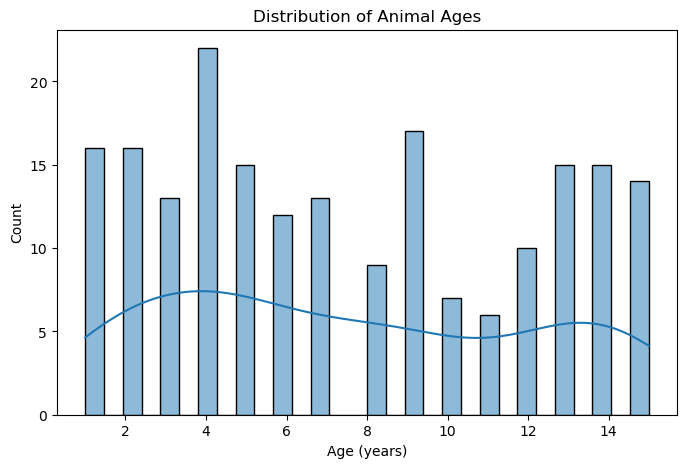

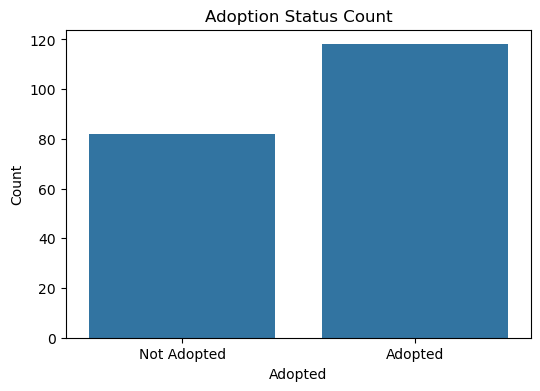

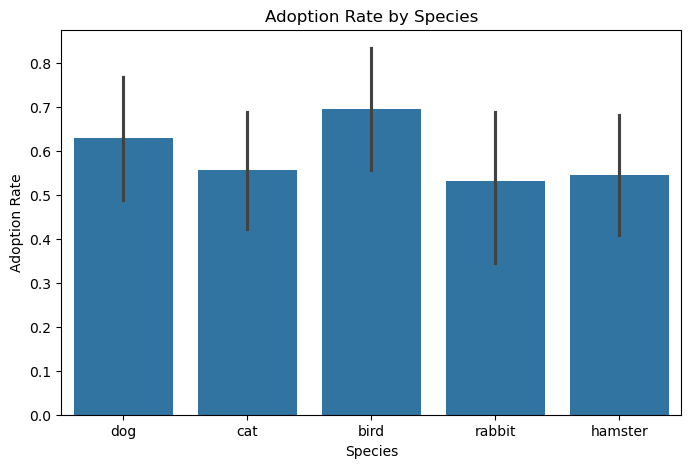

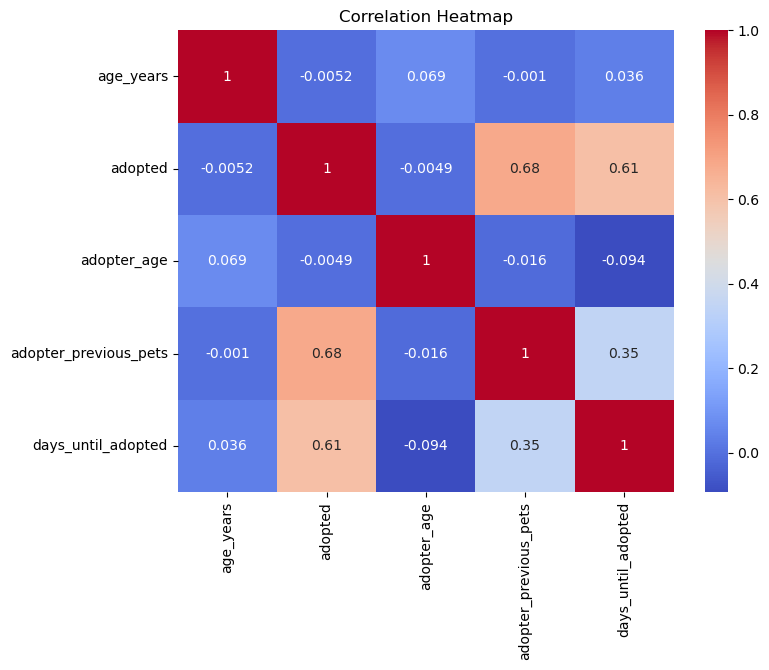

In [4]:
# Summary statistics
print(df.describe())

# Age distribution
plt.figure(figsize=(8,5))
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title('Distribution of Animal Ages')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

# Adoption status count
plt.figure(figsize=(6,4))
sns.countplot(x='adopted', data=df)
plt.title('Adoption Status Count')
plt.xlabel('Adopted')
plt.ylabel('Count')
plt.xticks([0,1], ['Not Adopted', 'Adopted'])
plt.show()

# Adoption rate by species
plt.figure(figsize=(8,5))
sns.barplot(x='species', y='adopted', data=df, estimator=np.mean)
plt.title('Adoption Rate by Species')
plt.ylabel('Adoption Rate')
plt.xlabel('Species')
plt.show()

# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##### 4. Regression Analysis: Age vs Days Until Adoption

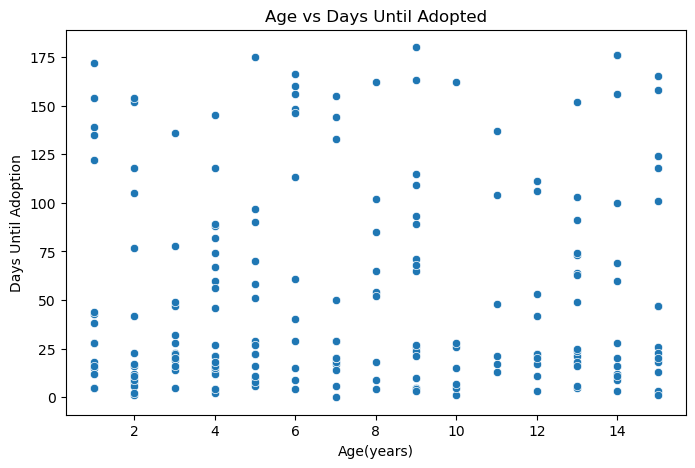

Mean Squared Error: 2527.93


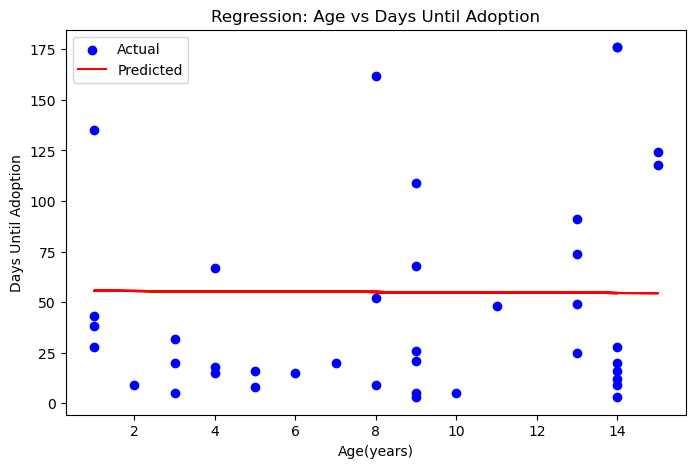

In [5]:
# Filter out animals not adopted (days_until_adopted = -1)
adopted_df = df[df['days_until_adopted'] >= 0]

# Scatter plot 
plt.figure(figsize=(8,5))
sns.scatterplot(x='age_years', y='days_until_adopted', data=adopted_df)
plt.title('Age vs Days Until Adopted')
plt.xlabel('Age(years)')
plt.ylabel('Days Until Adoption')
plt.show()

# Prepare data for regression
X = adopted_df[['age_years']]
y = adopted_df['days_until_adopted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#Prediction and evaluation
y_pred = lr.predict(X_test)
mse= mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Plot regression line
plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Regression: Age vs Days Until Adoption')
plt.xlabel('Age(years)')
plt.ylabel('Days Until Adoption')
plt.legend()
plt.show()

##### 5. Classification: Predicting Whether Animal is Adopted

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.84      0.91        25

    accuracy                           0.90        40
   macro avg       0.89      0.92      0.90        40
weighted avg       0.92      0.90      0.90        40

Confusion Matrix:
[[15  0]
 [ 4 21]]


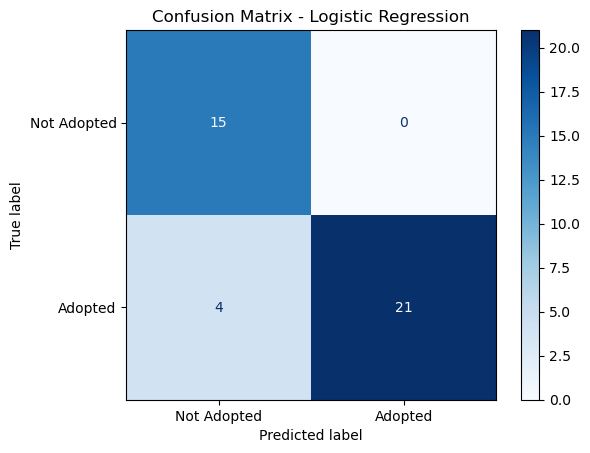

In [6]:
# Ensure adopted is 0 or 1
df['adopted'] = df['adopted'].astype(int)

# Encode categorical feature: species
df_encoded = pd.get_dummies(df, columns=['species'], drop_first=True)

# Select features and target
features = ['age_years', 'adopter_age', 'adopter_previous_pets'] + [c for c in df_encoded.columns if c.startswith('species_')]
X = df_encoded[features]
y= df_encoded['adopted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Plot Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, display_labels=['Not Adopted', 'Adopted'], cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()